In [5]:
import pickle
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


## Helper methods

In [85]:
def get_top_k_topics(document_with_topics, n = 3):
    """
    Get the top k topics for each document
    :param document_with_topics: document with topics
    :return: top k topics for each document
    """
    doci = {}
    for k in range(20):
        doci[k] = np.sum(document_with_topics == k)

    return sorted(doci, key=doci.get, reverse=True)[:n]

def find_top_k_words_for_topic(docs, topic_word_matrix, dictionary, topic, k = 20, plot = False):
    """
    Find the top k words for each topic
    :param topic_word_matrix: topic word matrix
    :param k: number of words to be returned
    :return: top k words for each topic
    """
    words_freq = {}
    for i in range(len(docs)):
        for j in range(len(docs[i])):
            if topic_word_matrix[i][j] == topic:
                if docs[i][j] in words_freq:
                    words_freq[docs[i][j]] += 1
                else:
                    words_freq[docs[i][j]] = 1
    # Top k words
    top_k_words = sorted(words_freq, key=words_freq.get, reverse=True)[:k]

    # Convert to words
    nums_2_words = map(lambda x: dictionary[x], top_k_words)

    if plot:
        plt.figure(figsize=(12, 8))
        sns.barplot(x=list(nums_2_words), y=list(words_freq.values())[:k])
        plt.show()

    return sorted(words_freq, key=words_freq.get, reverse=True)[:k]

def perplexity(docs, cw_mk, gamma):
    """
    Compute perplexity for a document
    :param w_nd: document
    :param docs: list of documents
    :param z_nd: topic assignment for each word in the document
    :param cw_mk: word count matrix
    :param c_k: topic count
    :param alpha: hyperparameter
    :param gamma: hyperparameter
    :return: perplexity
    """
    N_test = 0
    # Count the number of words in the test document
    for d in docs:
        N_test += len(d)

    H = 0
    suma_cw_mk = sum(cw_mk)
    for d in docs:
        N_d = len(d)
        for i in range(N_d):
            p = (gamma + cw_mk[d[i], :]) / (len(docs) * gamma + suma_cw_mk)
            H += np.log(p) 
    
    return 2**(-H / N_test)

## Load the data

In [10]:
# Load data from pickle file 
with open('dictionary.pkl', 'rb') as f:
    dictionary = pickle.load(f)

with open('preprocessed_docs.pkl', 'rb') as f:
    docs = pickle.load(f)

In [75]:
def p_w_given_k(C, gamma, M):
    return (C + gamma) / (M * gamma + np.sum(C))

# Define the entropy of a topic
def H_k(C, gamma, M):
    p = p_w_given_k(C, gamma, M)

    return -np.sum(p * np.where(p > 0, np.log2(p), 0))

# LDA algorithm for testing 
def lda_test(test_data, dicitonary, cw_mk, c_k, iterations=100, topics=20, alpha=0.01, gamma= 0.01):
    plot_iters = [1, 2, 5, 10, 20, 50, 100]

    # Word enteopy for each topic and iteration
    entropies = []

    # Longest document index in data
    longest_doc = np.argmax([len(doc) for doc in test_data])

    doc_cnt = len(test_data)
    word_cnt = len(dictionary)

    z = []
    # Init z_nd randomly
    for d in range(doc_cnt):
        N_d = len(test_data[d])
        z_nd = np.random.randint(0, topics, N_d)
        z.append(z_nd)

    # Compute cd_dk and cw_mk and c_k 
    cd_dk = np.zeros((doc_cnt, topics))

    # Compute cd_dk
    for d in range(doc_cnt):
        for k in range(topics):
            cd_dk[d, k] = np.sum(z[d] == k)
          
    # Compute cw_mk and c_k
    for m in range(word_cnt):
        for k in range(topics):
            cw_mk[m, k] = np.sum(z[:][m] == k)
            c_k[k] = np.sum(cw_mk[:][k])

    for i in range(1, iterations + 1):
        for d in range(doc_cnt):
            N_d = len(test_data[d])
            for n in range(0, N_d):
                znd = z[d][n]
                cd_dk[d, znd] -= 1

                p = np.zeros(topics)
                w_nd = test_data[d][n] 
                for k in range(topics):
                    p[k] =  (alpha + cd_dk[d, k]) * (gamma + cw_mk[w_nd, k]) / ((word_cnt * gamma + c_k[k]) * (topics * alpha + N_d - 1))
                # Normalize p
                p = p / np.sum(p)

                # Sample k from probability distribution p
                k = np.random.choice(topics, p = p)
                z[d][n] = k

                cd_dk[d, k] += 1
                
            # Compute entropy of topic k
        entropies.append([H_k(cw_mk[:, k], gamma, word_cnt) for k in range(topics)])
       
        # Plot distribution over topics for longest document
        if i in plot_iters:
            count_k = np.zeros(topics)
            for k in range(topics):
                count_k[k] = np.sum(z[longest_doc] == k)
            plt.bar(np.arange(topics), count_k)
            plt.xlabel('Topic')
            plt.ylabel('Count')
            plt.title('Iteration ' + str(i))
            plt.show()
            
    return cd_dk, z, entropies



def lda(data, dictionary, iterations = 100, topics = 20, alpha = 0.01, gamma = 0.01):
    """
    data: list of preprocessed documents
    dictionary: gensim.corpora.Dictionary object
    Plot the distribution over topics for the longest document in the data after
    initialization and after 1st, 2nd, 5th, 10th, 20th, 50th, and 100th iteration.
    Comment on these. (
    """
    plot_iters = [1, 2, 5, 10, 20, 50, 100]

    # Word enteopy for each topic and iteration
    entropies = []

    # Longest document index in data
    longest_doc = np.argmax([len(doc) for doc in data])

    doc_cnt = len(data)
    word_cnt = len(dictionary)

    z = []
    # Init z_nd randomly
    for d in range(doc_cnt):
        N_d = len(data[d])
        z_nd = np.random.randint(0, topics, N_d)
        z.append(z_nd)

    # Compute cd_dk and cw_mk and c_k 
    cd_dk = np.zeros((doc_cnt, topics))
    cw_mk = np.zeros((word_cnt, topics))
    c_k = np.zeros(topics)

    # Compute cd_dk
    for d in range(doc_cnt):
        for k in range(topics):
            cd_dk[d, k] = np.sum(z[d] == k)
          
    # Compute cw_mk and c_k
    for m in range(word_cnt):
        for k in range(topics):
            cw_mk[m, k] = np.sum(z[:][m] == k)
            c_k[k] = np.sum(cw_mk[:][k])

    for i in range(1, iterations + 1):
        for d in range(doc_cnt):
            N_d = len(data[d])
            for n in range(0, N_d):
                znd = z[d][n]
                cd_dk[d, znd] -= 1
                cw_mk[m, znd] -= 1
                c_k[znd] -= 1

                p = np.zeros(topics)
                w_nd = data[d][n] 
                for k in range(topics):
                    p[k] =  (alpha + cd_dk[d, k]) * (gamma + cw_mk[w_nd, k]) / ((word_cnt * gamma + c_k[k]) * (topics * alpha + N_d - 1))
                # Normalize p
                p = p / np.sum(p)

                # Sample k from probability distribution p
                k = np.random.choice(topics, p = p)
                z[d][n] = k

                cd_dk[d, k] += 1
                cw_mk[w_nd, k] += 1
                c_k[k] += 1
            
            # Compute entropy of topic k
        entropies.append([H_k(cw_mk[:, k], gamma, word_cnt) for k in range(topics)])
       
        # Plot distribution over topics for longest document
        if i in plot_iters:
            count_k = np.zeros(topics)
            for k in range(topics):
                count_k[k] = np.sum(z[longest_doc] == k)
            plt.bar(np.arange(topics), count_k)
            plt.xlabel('Topic')
            plt.ylabel('Count')
            plt.title('Iteration ' + str(i))
            plt.show()
            
    return cd_dk, cw_mk, c_k, z, entropies
                


/tmp/ipykernel_19011/784584508.py:8: RuntimeWarning: invalid value encountered in log2
  return -np.sum(p * np.where(p > 0, np.log2(p), 0))


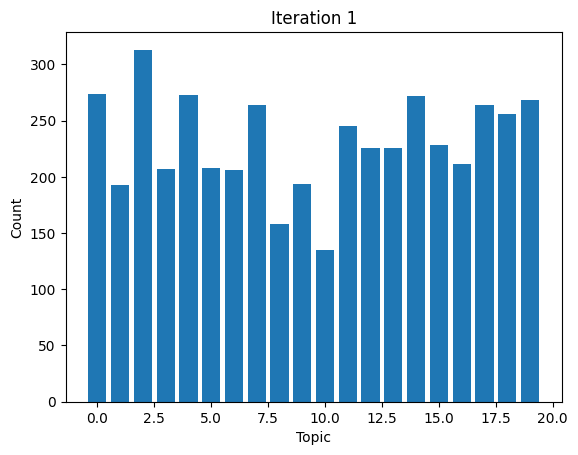

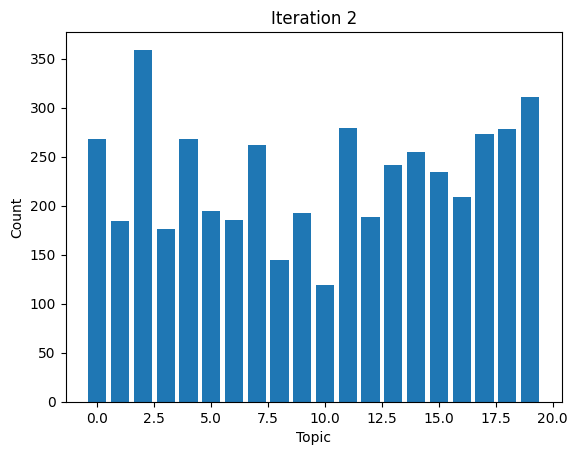

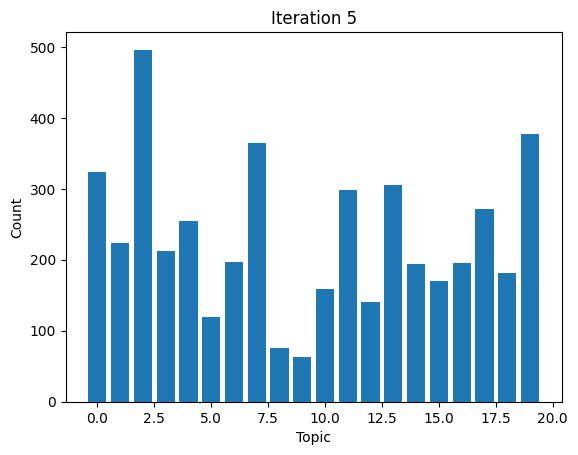

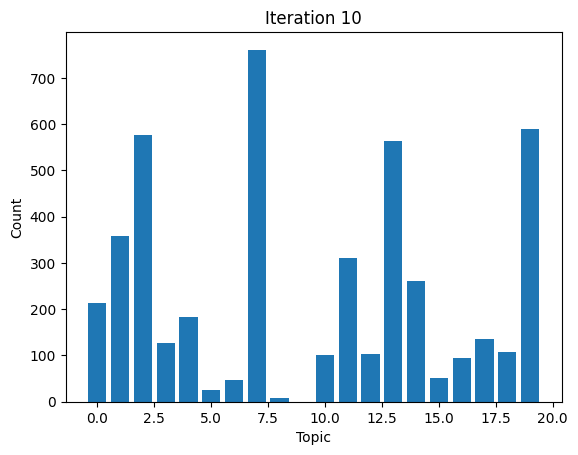

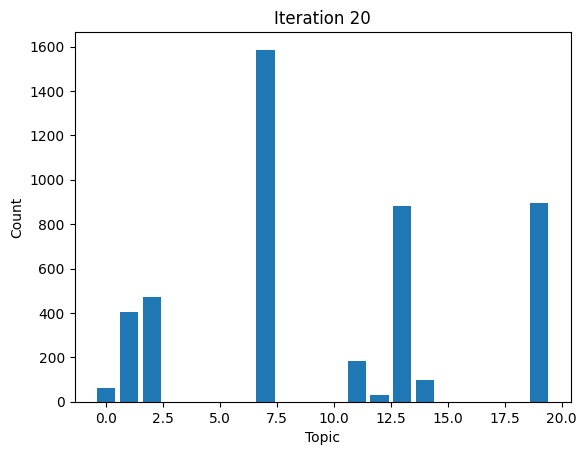

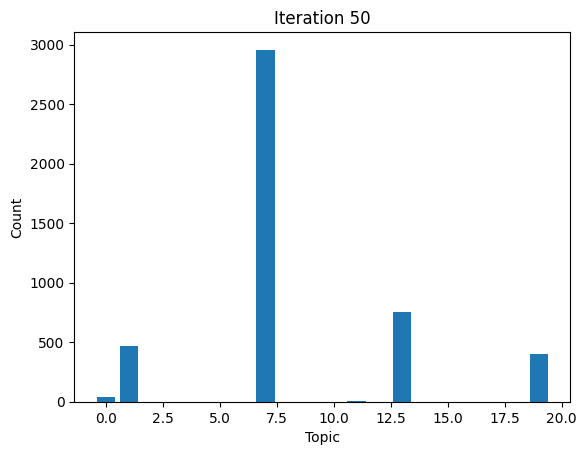

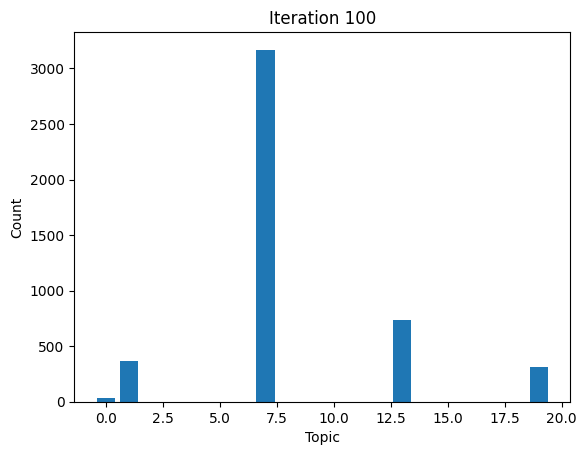

In [31]:
cd_dk, cw_mk, c_k, z_nd, entropies =lda(docs, dictionary)

In [32]:
# Save the results to pickle file
with open('cd_dk.pkl', 'wb') as f:
    pickle.dump(cd_dk, f)

with open('cw_mk.pkl', 'wb') as f:
    pickle.dump(cw_mk, f)

with open('c_k.pkl', 'wb') as f:
    pickle.dump(c_k, f)

with open('z_nd.pkl', 'wb') as f:
    pickle.dump(z_nd, f)

with open('entropies.pkl', 'wb') as f:
    pickle.dump(entropies, f)

In [33]:
# Load the results from pickle file
with open('cd_dk.pkl', 'rb') as f:
    cd_dk = pickle.load(f)

with open('cw_mk.pkl', 'rb') as f:
    cw_mk = pickle.load(f)

with open('c_k.pkl', 'rb') as f:
    c_k = pickle.load(f)

with open('z_nd.pkl', 'rb') as f:
    z_nd = pickle.load(f)

with open('entropies.pkl', 'rb') as f:
    entropies = pickle.load(f)

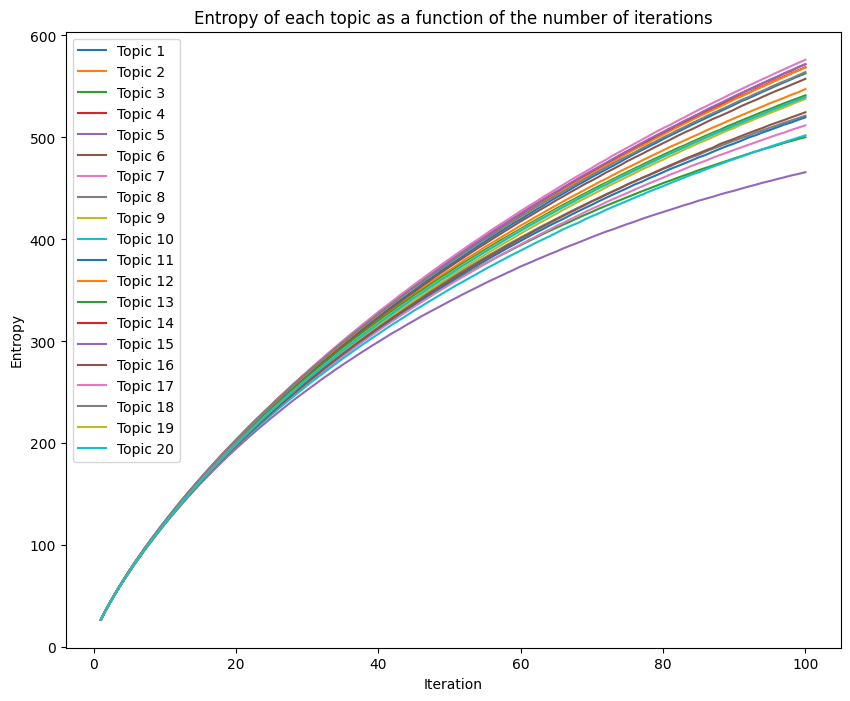

In [34]:
# Plot the entropy of each topic as a function of the number of iterations
plt.figure(figsize = (10, 8))
for k in range(20):
    plt.plot(np.arange(1, 101), np.array(entropies)[:, k], label = 'Topic ' + str(k + 1))
    plt.xlabel('Iteration')
    plt.ylabel('Entropy')
    plt.title('Entropy of each topic as a function of the number of iterations')
    plt.legend()
    


In [36]:
z_nd[1]

array([ 8,  8,  8,  8, 15,  8, 15,  8,  8, 15,  8,  8,  8,  8,  8, 15,  8,
        8, 15,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8, 15,  8,
        8,  8,  8,  8, 15,  8,  8, 15, 15,  8,  8,  8, 15, 15, 15,  8,  8,
        8, 15,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8])

###  Show histograms of the most frequent 20 words of three chosen topics after 100 Gibbs iterations. What are the chosen topics about?

#### Lets choose the 3 topics from longest document 

In [45]:
longest_doc = np.argmax([len(doc) for doc in docs])

# Take the most frequent 3 topics in the longest document
doci = get_top_k_topics(z_nd[longest_doc], 3)
    
doci

[7, 13, 1]

#### Now lets find the most frequent 20 words for each chosen topic

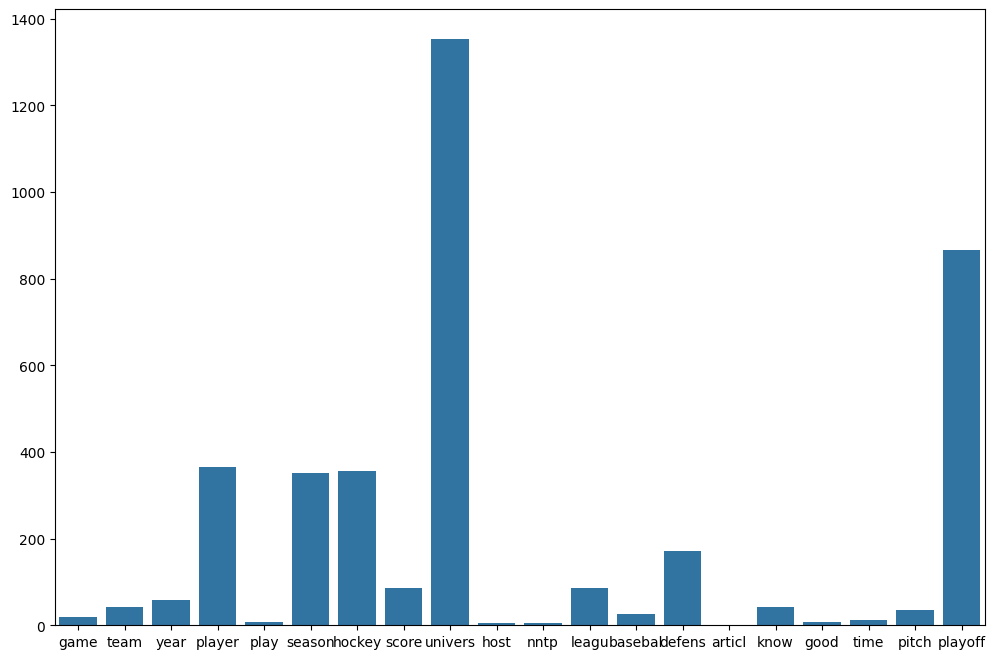

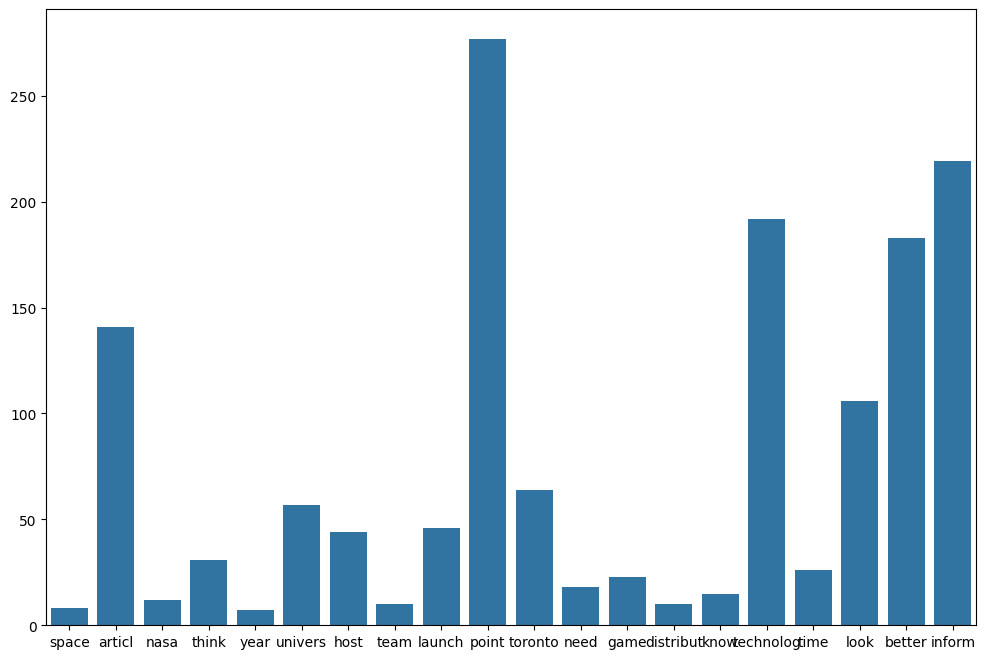

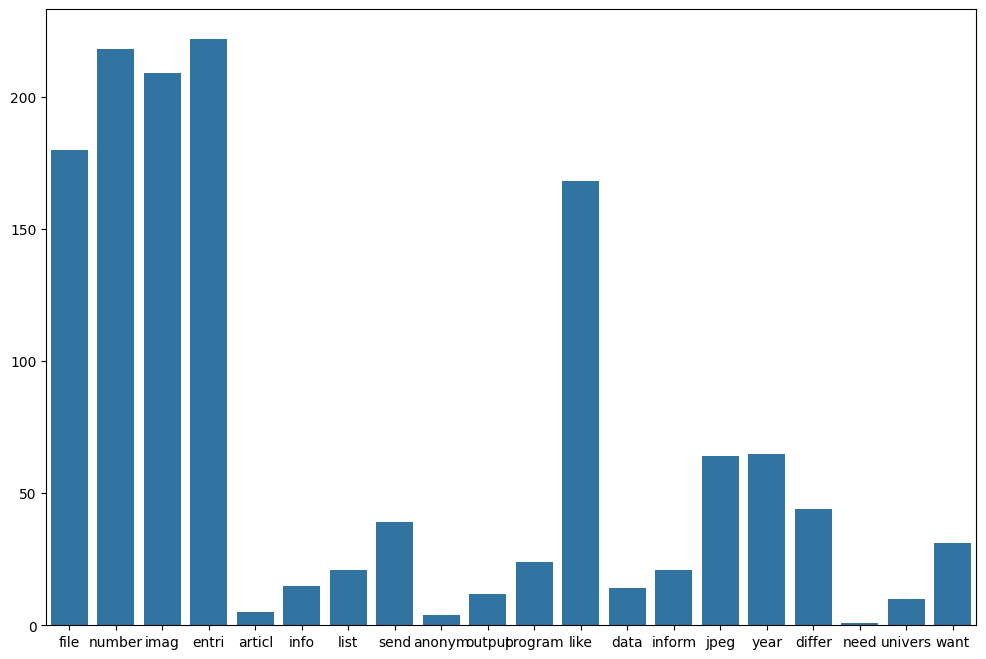

In [69]:
for topic in doci:
    top_n_words = find_top_k_words_for_topic(docs, z_nd, dictionary, topic, plot=True)
    

#### We can see that the first topic is hockey, 
#### The second is I think connected with astrology
#### Third topic is connected with data processing

### Preprocess the test data in the same way as the training data. For filtration, use the dictionary from the training data. Compute the per-word perplexity of the test data for the state after 50 Gibbs iterations. Compare it to a simple bayesian model not using any hidden variables and using only one distribution over words β for all documents with symmetric Dirichlet prior with and concentration parameter γ = 0.1.

In [72]:
# Load test data
with open('../preprocessed_docs_test.pkl', 'rb') as f:
    test_docs = pickle.load(f)

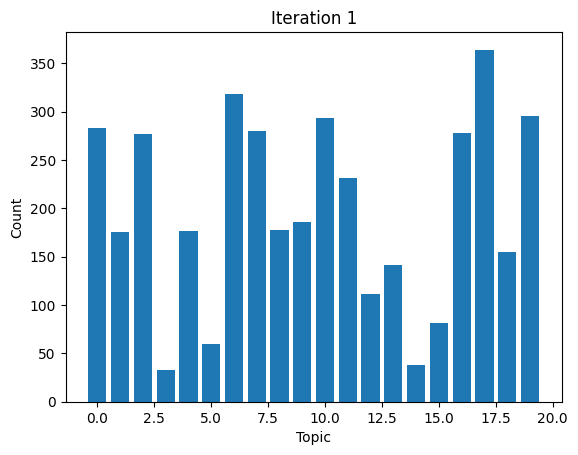

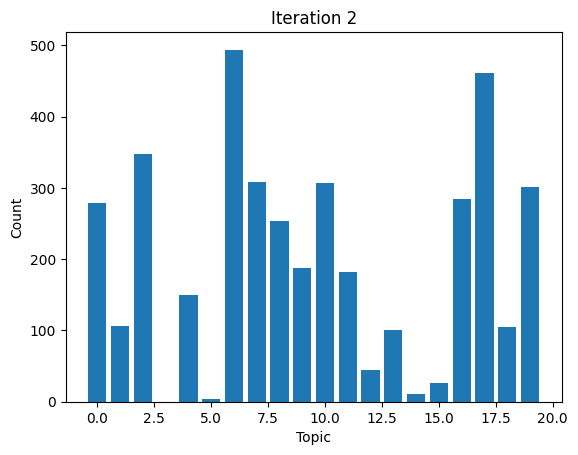

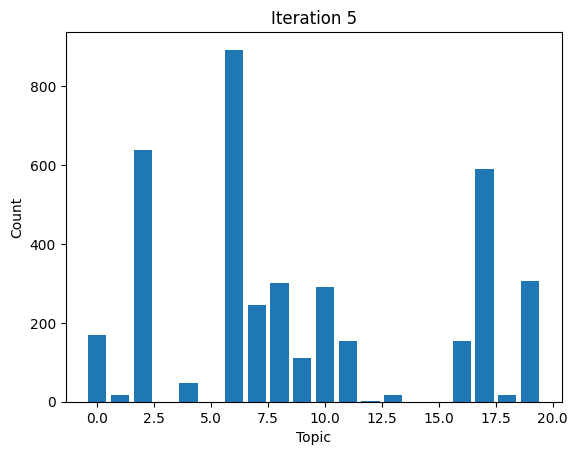

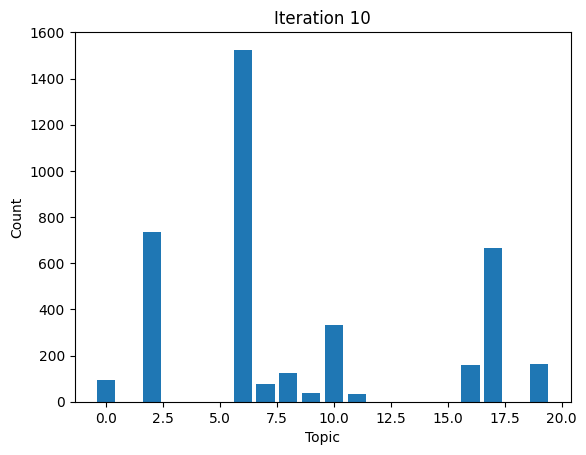

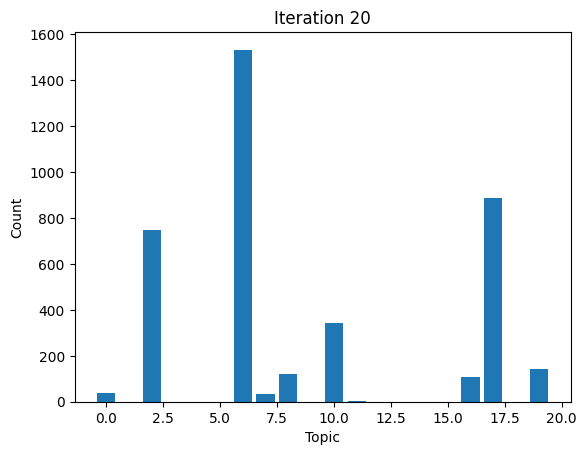

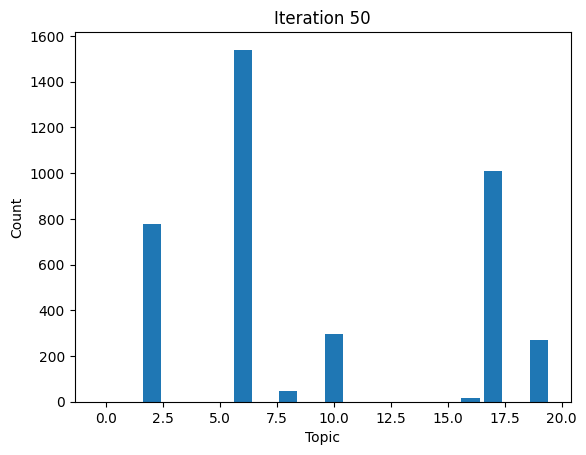

In [77]:
cd_dk_test, z_test, entropies_test = lda_test(test_docs, dictionary, cw_mk, c_k, iterations=50)

In [78]:
# Save the results to pickle file
with open('cd_dk_test.pkl', 'wb') as f:
    pickle.dump(cd_dk_test, f)

with open('z_test.pkl', 'wb') as f:
    pickle.dump(z_test, f)

with open('entropies_test.pkl', 'wb') as f:
    pickle.dump(entropies_test, f)


#### Now lets count the perplexity 

In [86]:
perplexity(test_docs, cw_mk, gamma=0.01)

array([804.88658362, 789.58909161, 770.08060859, 769.5038941 ,
       808.94565666, 794.15024303, 795.35273068, 793.42862131,
       812.14706536, 785.04698887, 789.34871443, 776.24412789,
       817.966886  , 809.26503571, 770.93271851, 803.41602621,
       800.27887675, 803.33198666, 807.66537411, 800.92711192])

#### Now lets do some experiments with alpha and gamma and topics

In [ ]:
experiments = {'experiment1': {'iterations': 10, 'topics': 10, 'alpha': 0.01, 'gamma': 0.01},
               'experiment2': {'iterations': 50, 'topics': 20, 'alpha': 0.5, 'gamma': 0.5},
                'experiment3': {'iterations': 50, 'topics': 10, 'alpha': 1, 'gamma': 1},
                'experiment4': {'iterations': 50, 'topics': 5, 'alpha': 10, 'gamma': 10}}



In [ ]:
for experiment in experiments:
    print('Experiment: ' + experiment)
    cd_dk, cw_mk, c_k, z_nd, entropies = lda(docs, dictionary, 
                                             iterations=experiments[experiment]['iterations'], 
                                             topics=experiments[experiment]['topics'], 
                                             alpha=experiments[experiment]['alpha'], 
                                             gamma=experiments[experiment]['gamma'])
    
    # Test data with test_lda
    cd_dk_test, z_test, entropies_test = lda_test(test_docs, dictionary, cw_mk, c_k, iterations=50)

    perplexity_test = perplexity(test_docs, cw_mk, gamma=experiments[experiment]['gamma'])
    print('Perplexity on test data: ' + str(perplexity_test))
    print('')